# Getting started with flows

**Goal:** This notebook shows some first steps using flows.

**Usage:** Try to understand the provided code.

**Dataset:** One dimnesional artifical data sets and the famous old faithfull data set. This dataset contains 272 waiting times between two eruptions of the old faithful Geyser in the Yellowstone national park.


In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


In [3]:
plt.figure(figsize=(3,7))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

<Figure size 216x504 with 0 Axes>

### Change of variables numerical [solution]

This code shows the what happens if you take uniform distributed data and square it.  

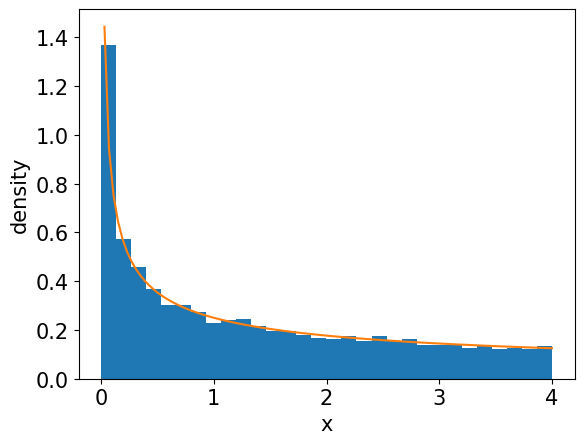

In [4]:
N = 10000
d = tfd.Uniform(low=0, high=2)
zs = d.sample(N)
x = zs**2

plt.hist(x, density=True, bins=30)
plt.ylabel('density')
plt.xlabel('x')

xs = np.linspace(0.03,4,100)
plt.plot(xs, 1./2 * 1./2 * 1/np.sqrt(xs))
plt.show()

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" /> 
This was probabily against your intuition, when you first saw the result. Continue to read the main text to learn on how to understand such transformations. 

### The Bijector package tfp.bijectors

Let's take the square as a bijector

z -- f(z)=z^2 --> x

In [5]:
f = tfb.Square() # This is a bijector
f.forward(2.0) #4
f.inverse(4.0) #2

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=2.0>

Let's use the uniform distribution as a base transformation, for the bijector as in the example before. 

In [6]:
base_dist = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution(distribution=base_dist, bijector=f) #My dist is a new distribution

In [7]:
mydist.prob(3), mydist.sample(3) #With that distribution you can do whatever you did with distributions

(<tf.Tensor: id=80, shape=(), dtype=float32, numpy=0.14433756>,
 <tf.Tensor: id=119, shape=(3,), dtype=float32, numpy=array([1.8927774 , 0.93887895, 3.4670022 ], dtype=float32)>)

Let's plot the transformed distribution. 

(0, 1)

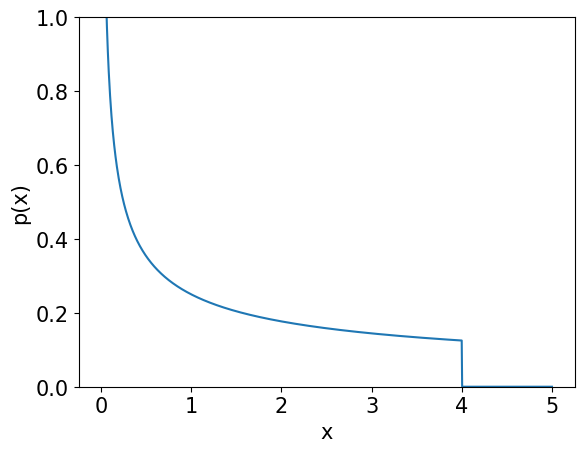

In [8]:
g = tfb.Square() #A 
db = tfd.Uniform(0.0,2.0)
mydist = tfd.TransformedDistribution( #B
    distribution=db, bijector=g)

xs = np.linspace(0.001, 5,1000)
px = mydist.prob(xs)

#A The bijector
#B Combining a base distribution and a bijector to a new distribution 

plt.plot(xs,px)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.ylim(0,1)

## Using several bijectors

In [9]:
chain = tfb.Chain([tfb.Square(), tfb.Square()], name="x4")
chain.forward(2.0)

<tf.Tensor: id=197, shape=(), dtype=float32, numpy=16.0>

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" /> You are now able to use Bijectors to create a flow. Let's go back to the main text and learn, how such flows can be trained.

# Training Bijectors

An extremly simple example, to go from a $N(0,1)$ Gaussian to a $N(5.0,0.2)$ Gaussian. 

#### Training Data
Let's sample some training data of our traget distribution:

(1000, 1)

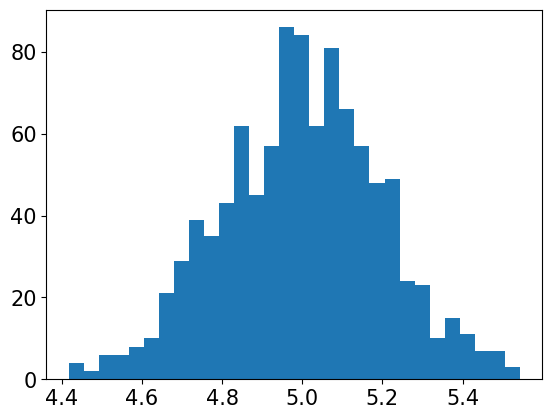

In [10]:
N = 1000
X = tfd.Normal(loc=5,scale=0.2).sample(1000)
X = X.numpy().reshape([N,1])
plt.hist(X,30)
X.shape

#### The simplest flow 


Building the flow using an Affine transformation in 1-D. Simply shift ($b$) and scale ($a$).

$$
    x = a \cdot z + b
$$


In [11]:
#Making a distribution using the flow and a N(0,1)
b = tf.Variable(0.0)
a=tf.Variable(1.0)
bijector = tfb.AffineScalar(shift=b, scale=a)
dist = tfd.TransformedDistribution(distribution=tfd.Normal(loc=0,scale=1),bijector=bijector)
dist.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>)

In [12]:
-tf.reduce_mean(dist.log_prob(X)) #The NLL of the whole training set

<tf.Tensor: id=290, shape=(), dtype=float32, numpy=13.427994>

#### Training in eager mode

What shall be the result? 

$z \sim N(0,1) \overbrace{\longrightarrow}^{f(z) = a\cdot z + b} x \sim N(5,0.2)$. 

Hence, $b = 5$ and $a = 0.2$

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1) #quite high lr for normalizing flows.

for i in range(1000):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss,          #D 
                    dist.trainable_variables)     
    optimizer.apply_gradients(
        zip(gradients, dist.trainable_variables)) #E     
    
    if (i % 100 == 0):
        print(i, "NLL ",loss.numpy(), " shift (a) ", a.numpy(), " scale (b) ", b.numpy())

0 NLL  13.427994  shift (a)  1.1  scale (b)  0.099999934
100 NLL  1.9112844  shift (a)  2.4511194  scale (b)  3.9801838
200 NLL  0.24631527  shift (a)  0.41396034  scale (b)  4.998811
300 NLL  -0.18727158  shift (a)  0.20031717  scale (b)  4.997778
400 NLL  -0.18727165  shift (a)  0.20064199  scale (b)  4.997785
500 NLL  -0.18727165  shift (a)  0.20064652  scale (b)  4.9977856
600 NLL  -0.18727165  shift (a)  0.20064652  scale (b)  4.9977846
700 NLL  -0.18727167  shift (a)  0.20064652  scale (b)  4.997784
800 NLL  -0.18727167  shift (a)  0.20064652  scale (b)  4.997785
900 NLL  -0.18727176  shift (a)  0.20064653  scale (b)  4.9977846


The learning did find parameters for a and b, which are quite similar to the theoretically expected ones.  

#### Visualizing the learnd distribution 
We now compare the learned flow and the original data

Text(0.5, 0, 'x')

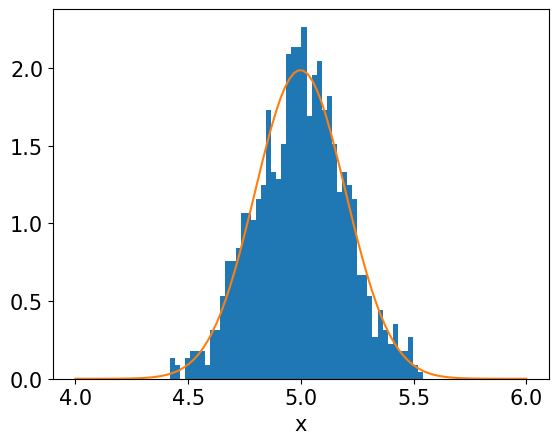

In [14]:
xx = np.linspace(4,6,100)
plt.hist(X, bins=50,density=True)
plt.plot(xx, dist.prob(xx) )
dist.trainable_variables
plt.xlabel('x')

In [15]:
dist.mean()
#dist.stddev() #not implemented for transformed model
dist.prob(4.6)
dist.quantile(0.2)

<tf.Tensor: id=140713, shape=(), dtype=float32, numpy=4.828916>

### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" /> Before, we continue with more complex distributions we need to learn who to chain distributions. Go back to 6.3.4 and learn about chaining.

## Fitting the old faithful

Finally we can start to deal with real world data such as the old-faithful geyser. 

(272, 1)

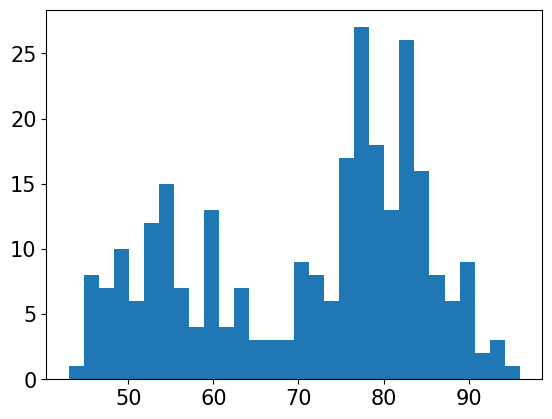

In [16]:
df1 = pd.read_csv('../data/faithful.csv', delimiter=',')
X = np.asarray(df1.iloc[:,2],dtype='float32').reshape((-1,1))
plt.hist(X,30)
X.shape

## Non-Linearity

The SinhArcsinh Bijector has a complicated name but looks quite promising: it has two parameters skewness and tailweight and if tailweight>0 there are no restrictions on x and z. In the following we plot that Bijector for some parameters.

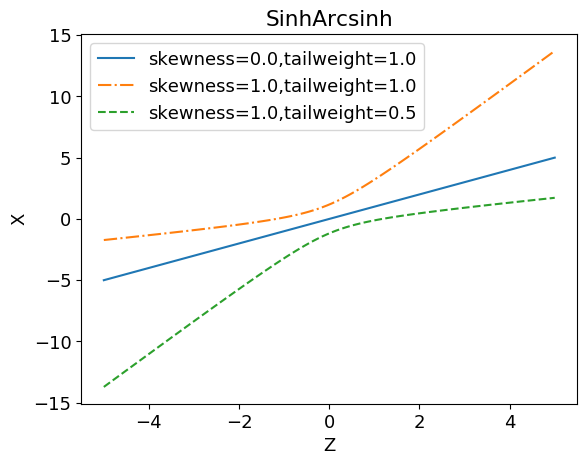

In [17]:
plt.rcParams.update({'font.size': 13}) #Macht grosse axen
zs = np.linspace(-5,5,100, dtype=np.float32)
plt.plot(zs, tfb.SinhArcsinh(skewness=0.0,tailweight=1.0).forward(zs))
plt.plot(zs, tfb.SinhArcsinh(skewness=1.0,tailweight=1.0).forward(zs),linestyle='-.')
plt.plot(zs, tfb.SinhArcsinh(skewness=-1.0,tailweight=1.0).forward(zs),linestyle='--')
plt.xlabel('Z')
plt.ylabel('X')
plt.title('SinhArcsinh')
plt.legend(['skewness=0.0,tailweight=1.0','skewness=1.0,tailweight=1.0','skewness=1.0,tailweight=0.5'])
plt.savefig('ch06_sin.pdf')

In [18]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234

num_bijectors = 5 #A 
bs=[]
for i in range(num_bijectors):
    
    shft = tf.Variable(0.0)
    sca=tf.Variable(1.0)
    bs.append(tfb.AffineScalar(shift=shft, scale=sca))#B
    
    skewness=tf.Variable(0.0)
    tailweight=tf.Variable(1.0) 
    bs.append(tfb.SinhArcsinh(skewness,tailweight))#C
    

bijector = tfb.Chain(bs) #D
dist = tfd.TransformedDistribution(distribution=
        tfd.Normal(loc=0,scale=1),bijector=bijector)

#A Number of layers
#B The AffineScalar transformation
#C The SinhArcsinh acting as non-linearity
#D Creating the chain of bijectors from the list bijectors

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function #Compiles function for fast execution
def train_step(X):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(dist.log_prob(X)) #C 
        gradients = tape.gradient(loss,dist.trainable_variables)     
        optimizer.apply_gradients(zip(gradients, dist.trainable_variables)) #E 
        return loss

for i in range(20000):
    loss = train_step(X)
    if (i % 2000 == 0 or i < 5):
        print(i, "NLL ",loss.numpy())

0 NLL  2606.1877
1 NLL  1541.5117
2 NLL  962.5718
3 NLL  635.1125
4 NLL  440.9034
2000 NLL  4.386953
4000 NLL  4.1083465
6000 NLL  4.0207634
8000 NLL  3.9419434
10000 NLL  3.8819408
12000 NLL  3.8407445
14000 NLL  3.8189259
16000 NLL  3.8069062
18000 NLL  3.800556


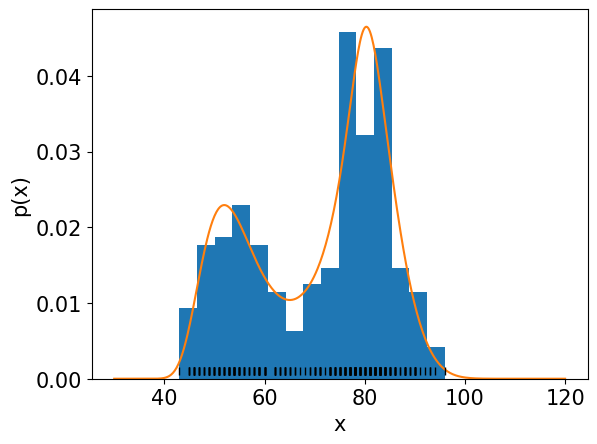

In [20]:
plt.rcParams.update({'font.size': 15}) #Macht grosse axen
plt.hist(X, 15,density=True)
xs = np.linspace(30,120,500)
plt.plot(xs, dist.prob(xs))
plt.plot(X, [0.001]*len(X), '|', color='k')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.savefig('ch06_gey.pdf')

The following is the learned transformation, which transforms a uniform Gaussian $N(0,1)$ to a distribution similar of the waiting times of old faithfull geyser. 

Text(0, 0.5, 'x')

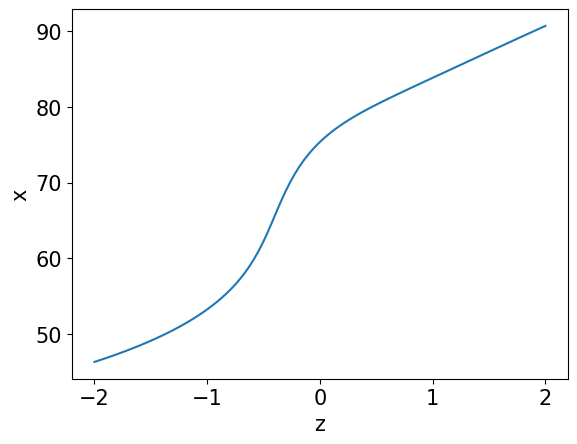

In [21]:
zz = np.linspace(-2,2,100)
plt.plot(zz, bijector.forward(zz))
plt.xlabel('z')
plt.ylabel('x')

#### Play around

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  There is not formel excercise here. As usual play around and try to break it. For example use a smaller number of projectors.  

